In [1]:
%matplotlib inline

import os
os.chdir('/Users/Sinead/DC-project/')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import script

import plotly 
plotly.offline.init_notebook_mode()

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
plt.ioff()

In [3]:
PathDicoms = np.array(
    [['/Volumes/Backup Data/ASDH Samples/Sample1/Post-operative/R-N11-109/HeadSpi  1.0  J40s  3', 'Sample 1'],
     ['/Volumes/Backup Data/ASDH Samples/Sample2/Original/Post-op.nii', 'Sample 2'],
     ['/Volumes/Backup Data/ASDH Samples/Sample3/Post-op', 'Sample 3'],
     ['/Volumes/Backup Data/ASDH Samples/Sample4/Post-op', 'Sample 4'],
     ['/Volumes/Backup Data/ASDH Samples/Sample5/Post-op', 'Sample 5'],
     ['/Volumes/Backup Data/ASDH Samples/SampleA/Post-op', 'Sample A'],
     ['/Volumes/Backup Data/ASDH Samples/SampleB/Post-op', 'Sample B'],
     ['/Volumes/Backup Data/ASDH Samples/SampleC/Post-op', 'Sample C'],
     ['/Volumes/Backup Data/ASDH Samples/SampleD/Post-op', 'Sample D'],
     ['/Volumes/Backup Data/ASDH Samples/SampleF/Post-op', 'Sample F'],
     ['/Volumes/Backup Data/ASDH Samples/SampleG/Post-op', 'Sample G'],
     ['/Volumes/Backup Data/ASDH Samples/SampleH/Post-op', 'Sample H'],
     ['/Volumes/Backup Data/ASDH Samples/SampleI/Post-op', 'Sample I']])

In [4]:
PathDicom = PathDicoms[5][0]
samp = PathDicoms[5][1]

In [5]:
if PathDicom.endswith('.nii'):
    post_700_threshold=script.threshim_nii(700,1500)
    array, ConstPixelSpacing = script.vtk2np_nii(post_700_threshold)
else:
    post_700_threshold=script.threshim_dicom(700,1500)
    array, ConstPixelSpacing = script.vtk2np(post_700_threshold)

In [6]:
reshaped_array3 = script.reshape(array,ConstPixelSpacing,220,160,array.shape[0],array.shape[2])
rotated2=reshaped_array3

In [66]:
# from scipy.ndimage.interpolation import rotate

# angle1rad = 0.164067954932
# angle2rad = 0.907180023618
# angle1 = 9.40040137094 # degrees
# angle2 = 51.9775866119 # degrees

# rotated1 = rotate(reshaped_array3, angle1, mode='nearest', axes=(2,0))
# rotated2 = rotate(rotated1, angle2*(1-np.sin(angle1rad)), mode='nearest', axes=(0,1))

In [7]:
numpy_array=rotated2[:,:,50]
for i in range(numpy_array.shape[0]):
    for j in range(numpy_array.shape[1]):
        if abs(numpy_array[i,j])<0.01:
            numpy_array[i,j] = 0
indices = np.nonzero(numpy_array)
x = indices[1]
y = indices[0]
points = np.zeros((len(indices[1]),2))
for i in range(len(indices[1])):
    points[i, 0] = x[i]
    points[i, 1] = y[i]

In [8]:
import b2ac.preprocess
import b2ac.fit
import b2ac.conversion
print points
points, x_mean, y_mean = b2ac.preprocess.remove_mean_values(points)


[[   1.   38.]
 [   1.   39.]
 [   0.   41.]
 ..., 
 [ 116.  208.]
 [ 117.  208.]
 [ 118.  208.]]


In [9]:

# Fit using NumPy methods in double precision.
# conic_numpy = b2ac.fit.fit_improved_B2AC_numpy(points)
# Fit using own written methods in double precision.
conic_double = b2ac.fit.fit_improved_B2AC_double(points)
# Fit using own written methods in 64-bit integer precision.
# conic_int = b2ac.fit.fit_improved_B2AC_int(points)

# Convert from conic coefficient form to general ellipse form.
# general_form_numpy = b2ac.conversion.conic_to_general_1(conic_numpy)
# general_form_numpy[0][0] += x_mean
# general_form_numpy[0][1] += y_mean

general_form_double = b2ac.conversion.conic_to_general_1(conic_double)
general_form_double[0][0] += x_mean
general_form_double[0][1] += y_mean

# general_form_int = b2ac.conversion.conic_to_general_int(conic_int)
# general_form_int[0][0] += x_mean
# general_form_int[0][1] += y_mean

103 108.492667358
73.5614218185 64.1595094762
-1.44480368954 -82.7811536353


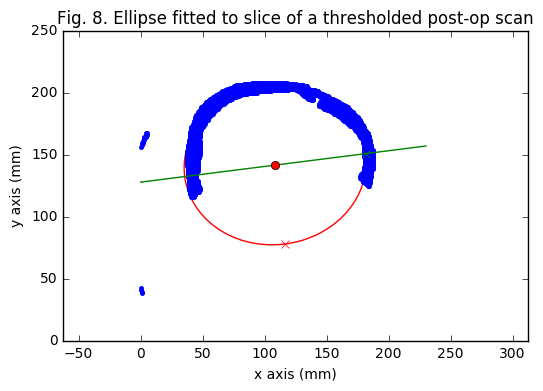

In [10]:
print x_mean, general_form_double[0][0]
xcentroid = general_form_double[0][0]
ycentroid = general_form_double[0][1]
xaxis = general_form_double[1][0]
yaxis = general_form_double[1][1]
angle = general_form_double[2] #anticlockwise is positive

plt.clf()
plt.plot(indices[1],indices[0], '.')
y = np.linspace(0,220)-y_mean
x = np.linspace(0,220)-x_mean
x,y = np.meshgrid(x,y)
plt.contour(x+x_mean,y+y_mean,(conic_double[0]*x**2 + conic_double[1]*x*y + conic_double[2]*y**2 + conic_double[3]*x + conic_double[4]*y + conic_double[5]),[0], colors='r')
x = np.linspace(0,230)
y = ycentroid + (x-xcentroid)*np.tan(angle+np.pi/2)
plt.plot(x,y)
plt.plot(xcentroid, ycentroid, 'o')
if xaxis>yaxis:
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x',color='red')
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x', color='green')
else:
    plt.plot(xcentroid+xaxis*np.cos(angle),ycentroid+xaxis*np.sin(angle),'x',color='red')
    plt.plot(xcentroid+yaxis*np.cos(angle+np.pi/2),ycentroid+yaxis*np.sin(angle+np.pi/2),'x', color='green')
print yaxis, xaxis
print angle, angle/(2*np.pi)*360

plt.xlabel('x axis (mm)')
plt.ylabel('y axis (mm)')
plt.title('Fig. 8. Ellipse fitted to slice of a thresholded post-op scan')
# plt.xlim([0,220])
plt.ylim([0,220])
plt.axis('equal')
plt.show()

In [14]:
from script import orientation
angles=np.zeros(rotated2.shape[2])
xcentroids=np.zeros(rotated2.shape[2])
ycentroids=np.zeros(rotated2.shape[2])
xmajor_axis_points=np.zeros(rotated2.shape[2])
ymajor_axis_points=np.zeros(rotated2.shape[2])

for i in range(rotated2.shape[2]):
    try:
        array_i=rotated2[:,:,i] # array to pass to 'orientation' must be thresholded already
        orientation_i=orientation(array_i)
        angles[i]=orientation_i[2] # pick out the angle
        xcentroids[i]=orientation_i[0][0]
        ycentroids[i]=orientation_i[0][1]
        xmajor_axis_points[i] = xcentroids[i]+orientation_i[1][1]*np.cos(angle)
        ymajor_axis_points[i] = ycentroids[i]+orientation_i[1][1]*np.sin(angle)
    except:
        pass

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning:

Mean of empty slice.

/Users/Sinead/anaconda/envs/project/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning:

invalid value encountered in double_scalars



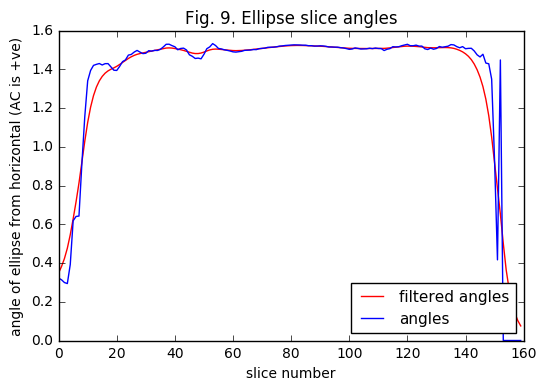

In [15]:
# make all angles positive
angles[angles < 0] += np.pi

import scipy.signal as signal
# First, design the Butterworth filter
N  = 1   # Filter order - the higher the order, the sharper the dropoff
pd = float(20)  # Cutoff period - the inverse is the cutoff frequency
fs = 1 # Sample rate frequency
nyq = 0.5*fs
low = 1/pd
wn = low/nyq # Cutoff frequency as a fraction
b, a = signal.butter(N, wn, output='ba')
filt_angles = signal.filtfilt(b,a, angles)
plt.plot(filt_angles,'r-',label='filtered angles')
plt.plot(angles,'b-', label = 'angles')
plt.xlabel('slice number')
plt.ylabel('angle of ellipse from horizontal (AC is +ve)')
plt.legend(fontsize=11, loc='lower right')
plt.title('Fig. 9. Ellipse slice angles')
plt.show()

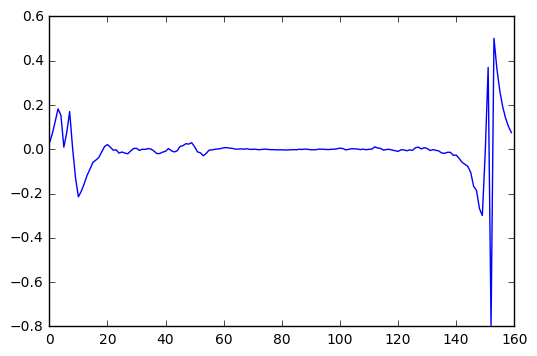

[[(141, 150)], [0], [(16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100), (100, 101), (101, 102), (102, 103), (103, 104), (104, 105), (105, 106), (106, 107), (107, 108), (108, 109), (109, 110), (110, 111), (111, 

[16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141]

In [16]:
angles_diff = filt_angles-angles
plt.plot(angles_diff)
plt.show()

indices = [] # indices holds the slice range of interest
for i in range(len(angles)):
    if abs(angles_diff[i]) < 0.05:
        indices.append(i)
from itertools import groupby
z = zip(indices, indices[1:])
tmp = ([list(j) for i, j in groupby(z, key=lambda x: (x[1] - x[0]) <= 1)])
tmp = sorted(tmp, key=len) # longest lists at the end
for i in range(len(tmp)):
    if min(tmp[i])[0] <10:
        tmp[i] = [0]
    elif max(tmp[i])[1] > (len(angles)-10):
        tmp[i] = [0]
print tmp
tmp = sorted(tmp, key=len) # longest lists at the end
maxtmp = np.array(max(tmp, key=len))
maxindices = list(range(maxtmp[0][0], maxtmp[-1][-1]+1))



slices = maxindices
slice_angles = [angles[i] for i in slices]
slices

In [17]:
head_angles = [angles[i] for i in slices]
head_x = [xcentroids[i] for i in slices] 
head_y = [ycentroids[i] for i in slices] 

mean_angle = np.mean(head_angles)
print mean_angle/(2*np.pi)*360

86.0570810578


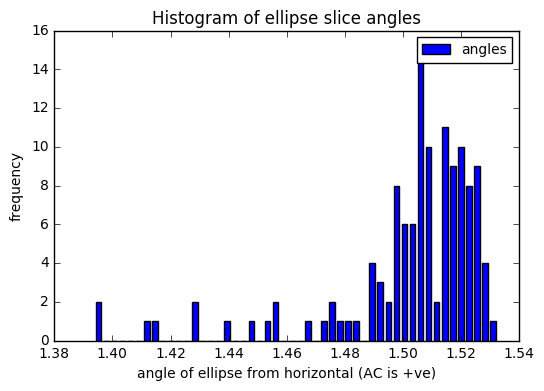

In [31]:
hist, bins = np.histogram(head_angles, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label='angles')
plt.xlabel('angle of ellipse from horizontal (AC is +ve)')
plt.ylabel('frequency')
plt.legend(fontsize=10)
plt.title('Histogram of ellipse slice angles')
plt.show()


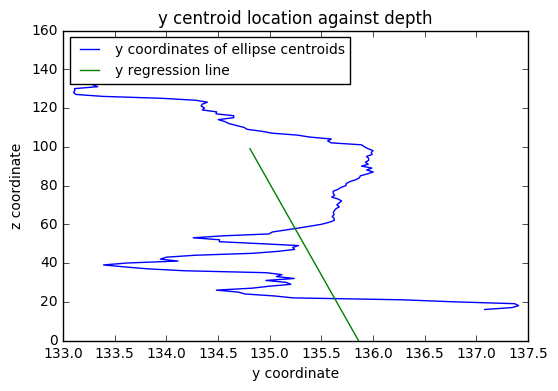

(-0.031620899477606379,
 119.71700292581006,
 -0.010603872107297407,
 135.85775642233341)

In [32]:
# find a plane
from scipy.optimize import curve_fit
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B
A_x,B_x = curve_fit(f, slices, head_x)[0] # your data x, y to fit
A_y,B_y = curve_fit(f, slices, head_y)[0] # your data x, y to fit

# allow function to be horizonal or vertical by analysing least squared error
plt.clf()
plt.plot(head_x, slices, label='x coordinates of ellipse centroids')
x = np.arange(0, 100, 1)
plt.plot(A_x*x + B_x, x, label='x regression line') 
# plt.xlim(head_x[0]-5,head_x[-1]+5)
# plt.ylim(slices[0]-5,slices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.title('x centroid location against depth')
plt.show()

plt.clf()
plt.plot(head_y, slices, label='y coordinates of ellipse centroids')
plt.plot(A_y*x + B_y, x, label='y regression line') 
# plt.xlim(head_y[0]-5,head_y[-1]+5)
# plt.ylim(slices[0]-5,slices[-1]+5)
plt.legend(fontsize=10, loc=2)
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')
plt.title('y centroid location against depth')
plt.show()

A_x,B_x,A_y,B_y

In [33]:
def round2zero(bone):
    for i in range(bone.shape[0]):
        for j in range(bone.shape[1]):
            for k in range(bone.shape[2]):
                if abs(bone[i,j,k])<0.01 or ~np.isfinite(bone[i,j,k]):
                    bone[i,j,k]=0
    return bone

In [44]:
rotated2[abs(rotated2)<0.01] = 0
rotated2[~np.isfinite(rotated2)]=0

In [69]:
x=[]
y=[]
remaining_z = range(rotated2.shape[2]-1, slices[-1],-1)
for i in remaining_z:
    x.append(np.mean(np.nonzero(rotated2[:,:,i])[1]))
    y.append(np.mean(np.nonzero(rotated2[:,:,i])[0]))
centroids_array = np.concatenate((np.array([head_x,head_y,slices]).T, np.array([x,y,remaining_z]).T),axis=0).T

In [57]:
centroids_array[~np.isfinite(centroids_array)]=0

In [60]:
reload(script)
from script import reject_outliers
centroids_array = reject_outliers(centroids_array)

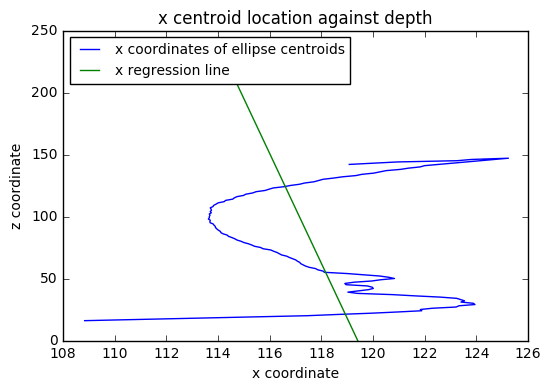

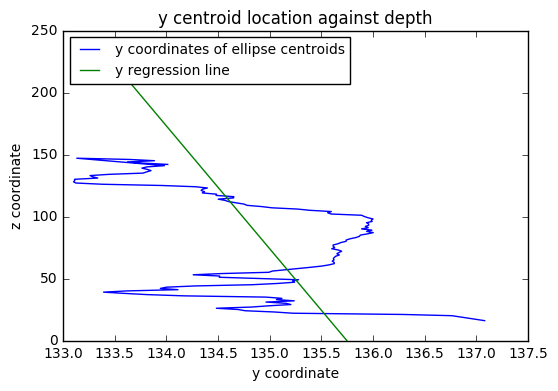

(-0.031620899477606379,
 119.71700292581006,
 -0.010603872107297407,
 135.85775642233341)

In [48]:
def f(x,A,B):
    return A*x + B

A_x1,B_x1 = curve_fit(f, centroids_array[2], centroids_array[0])[0] # your data x, y to fit
A_y1,B_y1 = curve_fit(f, centroids_array[2], centroids_array[1])[0] # your data x, y to fit

# allow function to be horizonal or vertical by analysing least squared error
plt.clf()
plt.plot(centroids_array[0], centroids_array[2], label='x coordinates of ellipse centroids')
x = np.arange(0, 220, 1)
plt.plot(A_x1*x + B_x1, x, label='x regression line') 
plt.legend(fontsize=10, loc=2)
plt.xlabel('x coordinate')
plt.ylabel('z coordinate')
plt.title('x centroid location against depth')
plt.show()

plt.clf()
plt.plot(centroids_array[1], centroids_array[2], label='y coordinates of ellipse centroids')
plt.plot(A_y1*x + B_y1, x, label='y regression line') 
plt.legend(fontsize=10, loc=2)
plt.xlabel('y coordinate')
plt.ylabel('z coordinate')
plt.title('y centroid location against depth')
plt.show()

A_x,B_x,A_y,B_y

In [49]:
np.mean(np.array(centroids_array)[:,0].tolist())

87.304241000719443

In [50]:
x_point = np.mean(np.array(centroids_array)[:,0].tolist()) # your data x, y to fit
y_point = np.mean(np.array(centroids_array)[:,1].tolist()) # your data x, y to fit
z_point = np.mean(np.array(centroids_array))

In [51]:
from mpl_toolkits.mplot3d import Axes3D
# Ax + B = z (for now) and Ay + B = z
z = np.median(slices)
x = A_x1*z + B_x1
y = A_y1*z + B_y1
# point that the plane goes through, p
p = np.array([x, y, z]) # coordinates when z = mean(indices)

# one vector of plane, v1
v1 = np.array([A_x1, A_y1, 1])

# one vector of plane, v1
# z = slices[0]
# x = A_x*z + B_x
# y = A_y*z + B_y
# v1 = np.array([x_point-x, y_point-y, z_point-z])

# second vector of plane, v2
v2 = np.array([np.cos(mean_angle+np.pi/2), np.sin(mean_angle+np.pi/2), 0])

normal = np.cross(v1,v2)
# a plane is ax+by+cz = d - find d
d = np.dot(p,normal)

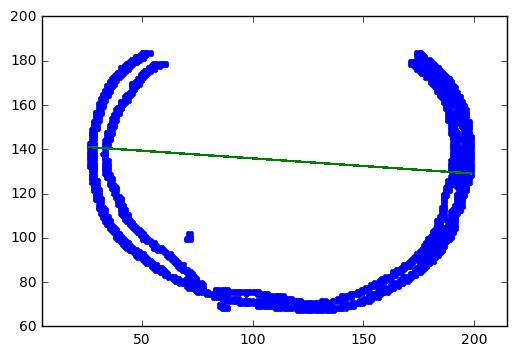

In [52]:
# superpose plane onto slices
a = normal[0]
b = normal[1]
c = normal[2]
# plane equation is ax+by+cz = d
# for each slice substitute slice number into z to get equation

slice_no = 100
numpy_array=rotated2[:,:,slice_no]
skull = np.nonzero(numpy_array)
x = skull[1]
y = skull[0]
plt.plot(x,y, '.')
plt.axis('equal')
plt.plot(x, (d-c*slice_no-a*x)/b)
plt.show()


In [53]:
bone = rotated2

In [54]:
post_700_threshold=script.threshim_nii(-100,1500) # change this line to dicom/nii
array, ConstPixelSpacing = script.vtk2np_nii(post_700_threshold) # change this line to dicom/nii
reshaped_array3 = script.reshape(array,ConstPixelSpacing,220,160,512,227)
rotated2=reshaped_array3
# from scipy.ndimage.interpolation import rotate

# angle1rad = 0.164067954932
# angle2rad = 0.907180023618
# angle1 = 9.40040137094 # degrees
# angle2 = 51.9775866119 # degrees

# rotated1 = rotate(reshaped_array3, angle1, mode='nearest', axes=(2,0))
# rotated2 = rotate(rotated1, angle2*(1-np.sin(angle1rad)), mode='nearest', axes=(0,1))

In [55]:
from plotly.graph_objs import *


slice_no = 60
slice_ = rotated2[:,:,slice_no]

heatmap = Heatmap(
        z = slice_,
        colorscale=[[0.0, 'rgb(160,160,160)'], 
                    [0.1111111111111111, 'rgb(20,20,20)'], 
                    [0.2222222222222222, 'rgb(40,40,40)'], 
                    [0.3333333333333333, 'rgb(100,100,100)'], 
                    [0.4444444444444444, 'rgb(120,120,120)'], 
                    [0.5555555555555556, 'rgb(140,140,140)'], 
                    [0.6666666666666666, 'rgb(160,160,160)'], 
                    [0.7777777777777778, 'rgb(170,170,170)'], 
                    [0.8888888888888888, 'rgb(250,250,250)'], 
                    [1.0, 'rgb(250,250,250)']]
        )

x = np.linspace(0,slice_.shape[0], 2)
y = (d-c*slice_no-a*x)/b

midline = Scatter(
    x = x,
    y = y,
    mode = 'lines'
)

layout = Layout(
    width = 600,
    height= 500,
#     title='Fig. 10. Slice number %i' % slice_no,
    title='Fig. 10. Slice of the midplane found', # title for report
    showlegend = False,
        margin= Margin(
        l=50,
        r=50,
        b=100,
        t=50,
        pad=4
        ),
    yaxis=dict(
        range=[50, 220]
    ),
    xaxis=dict(
        range=[0, 220]
    )
)

centroid = Scatter(
    x = [A_x1*slice_no + B_x1],
    y = [A_y1*slice_no + B_y1],
#     mode = 'lines'
)

data = [heatmap, midline, centroid]
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [56]:
plotly.offline.init_notebook_mode()
from plotly.graph_objs import *

for slice_no in range(0,160,5):
    slice_ = rotated2[:,:,slice_no]

    heatmap = Heatmap(
            z = slice_,
            colorscale = 'Greys'
            )

    x = np.linspace(0,slice_.shape[0], 2)
    y = (d-c*slice_no-a*x)/b

    midline = Scatter(
        x = x,
        y = y,
        mode = 'lines'
    )

    layout = Layout(
        width = 600,
        height= 600,
        title='Slice number %i' % slice_no
    )
    data = [heatmap, midline]
    fig = Figure(data=data, layout=layout)
    plotly.plotly.image.save_as(fig, filename='{0}_smallrange_adjusted.png'.format(slice_no))

plotly.offline.iplot(fig)

KeyboardInterrupt: 

In [ ]:
# to do
# write a function to find a plane of symmetry. optimise parameters using scipy optimise
# optimise x0, y0, z0, m, n where m is tilt and n is orientation
# send out email with meeting minutes